In [54]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import gc,re, nltk
from sklearn.model_selection import train_test_split
from kernel import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
sns.set(style="whitegrid", color_codes=True)
import lightgbm as lgb
%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0,6.0)



import eli5
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import TruncatedSVD

In [2]:
print('Loading Dataset...')
train = pd.read_table("train.tsv")
test = pd.read_table("test.tsv")
print('Dataset loaded!...')

Loading Dataset...
Dataset loaded!...


In [3]:
train.shape

(1482535, 8)

In [4]:
dftt = train[(train.price < 1.0)]
train = train.drop(train[(train.price < 1.0)].index)
print(train.shape)
del dftt['price']
nrow_train = train.shape[0] #-dftt.shape[0]
# nrow_test = train.shape[0] + dftt.shape[0]
print(train.shape, dftt.shape, test.shape)
merge: pd.DataFrame = pd.concat([train, dftt])
print(merge.shape)
# submission: pd.DataFrame = test[['test_id']]

(1481661, 8)
(1481661, 8) (874, 7) (693359, 7)
(1482535, 8)


In [5]:
del train
del test
gc.collect()

22

In [6]:
merge['general_cat'], merge['subcat_1'], merge['subcat_2'] = \
    zip(*merge['category_name'].apply(lambda x: split_cat(x)))
merge.drop('category_name', axis=1, inplace=True)

In [7]:
def get_bundle(x):
    if ('bundle' in x['item_description'].lower()) or ('bundle' in x['name'].lower()):
        return 1
    else:
        return 0

In [8]:
# %%time
# merge['item_description'] = merge['item_description'].fillna('None')
# merge['is_bundle'] = merge[['item_description','name']].apply(get_bundle, axis=1)
# # merge[['item_description','name']].shape

In [9]:
y_train = np.log1p(merge['price'])
merge['general_cat'] = merge['general_cat'].fillna('Other').astype(str)
merge['subcat_1'] = merge['subcat_1'].fillna('Other').astype(str)
merge['subcat_2'] = merge['subcat_2'].fillna('Other').astype(str)
merge['brand_name'] = merge['brand_name'].fillna('missing').astype(str)
merge['shipping'] = merge['shipping'].astype(str)
# merge['is_bundle'] = merge['is_bundle'].astype(str)
merge['item_condition_id'] = merge['item_condition_id'].astype(str)
merge['item_description'] = merge['item_description'].fillna('None')

In [10]:
y_train = y_train[:nrow_train]

In [11]:
(merge[:nrow_train].index == y_train.index).any()

True

In [12]:
y_train.tail()

1482530    3.044522
1482531    2.708050
1482532    2.564949
1482533    3.828641
1482534    3.135494
Name: price, dtype: float64

In [13]:
print(merge.shape)
merge.columns

(1482535, 10)


Index(['brand_name', 'item_condition_id', 'item_description', 'name', 'price',
       'shipping', 'train_id', 'general_cat', 'subcat_1', 'subcat_2'],
      dtype='object')

In [90]:
%%time

# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(merge.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    
vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('general_cat', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('general_cat'))),
    ('subcat_1', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('subcat_1'))),
    ('subcat_2', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('subcat_2'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('Quantity', merge['qnt']),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        preprocessor=build_preprocessor('item_description'))),
])
X_train = vectorizer.fit_transform(merge.values)
X_train

TypeError: All estimators should implement fit and transform. '0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           7
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1
16          1
17          1
18          1
19          1
20          1
21          1
22          1
23          1
24          1
25          1
26          1
27          1
28          1
29          1
           ..
1430798     1
1432284     1
1440173     1
1440325     1
1442657     1
1445675     1
1446187     1
1449089    16
1449359     1
1449450     1
1452401     1
1456460     1
1458474     1
1460118     2
1461712     1
1462168     1
1463021     1
1463174     1
1463577     1
1464583     1
1465545     1
1467318     1
1467698     1
1469806    11
1471721     1
1474172     1
1474198     1
1477958     1
1478519     4
1478813     1
Name: qnt, Length: 1482535, dtype: int64' (type <class 'pandas.core.series.Series'>) doesn't

In [93]:
X_train.shape

(1481661, 155813)

In [16]:
X_train = X_train[:nrow_train]

In [17]:
y_train.shape

(1481661,)

In [28]:
# X_train_sample = X_train.sample(n=2000)
print(np.random.randint(2000, size=100))

[ 540 1723  538  799 1591 1835 1960   22 1544  387   50 1089 1387 1005 1633
  138 1267  169  174 1095  482 1558  525  435 1822 1949 1964  867 1601 1586
  946 1270 1771   76  610  685  125 1001 1086 1663  562  721  950  109 1957
 1406  136  556  885    5  326  941 1231 1198 1974 1623 1103 1189  629  542
 1332 1430 1079  643  146 1229  989  246  688 1629 1841  381  742 1028 1342
  678 1272 1594 1556 1348 1614 1081  523 1140 1158  521  995  369 1890 1008
 1051 1567 1790  467 1886  676 1161  744 1039 1429]


In [38]:
%%time
# Fit SVD to data
svd = TruncatedSVD(n_components=200, random_state=42)
svd.fit(X_train[np.random.randint(X_train.shape[0], size=10000),:])

CPU times: user 24.3 s, sys: 1.61 s, total: 25.9 s
Wall time: 10.2 s


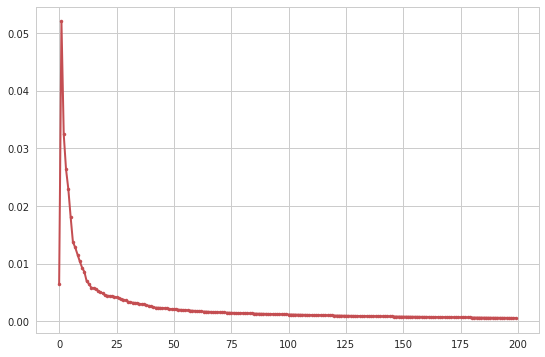

In [39]:
plt.plot(svd.explained_variance_ratio_, 'r.-', linewidth=2)

In [18]:
print(y_train.index.max())

1482534


In [98]:
print(X_train.shape)
y_train.shape

(1481661, 155813)


(1481661,)

In [105]:
# X_train[train_ids]
X_train[[1,2]]

TypeError: 'coo_matrix' object is not subscriptable

In [102]:
%%time

def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.1,
        max_iter=100,
        normalize=False,
        random_state=101,
        copy_X=True,
        tol=0.05)
    model.fit(X_train[train_ids], y_train.iloc[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = get_rmsle(y_pred_valid, y_train.iloc[valid_ids])
    print(f'valid rmsle: {rmsle:.5f}')
    break
y_pred_train = model.predict(X_train[~valid_ids])
train_rmsle = get_rmsle(y_pred_train, y_train.iloc[~valid_ids])
print(f'train rmsle: {train_rmsle:0.6f}')

TypeError: only integer scalar arrays can be converted to a scalar index

In [21]:
y_pred_valid = pd.Series(y_pred_valid, index=y_train.iloc[valid_ids].index)

In [22]:
residuals = y_pred_valid - y_train.iloc[valid_ids]

[Text(0,0.5,'Observed'), Text(0.5,0,'Predicted')]

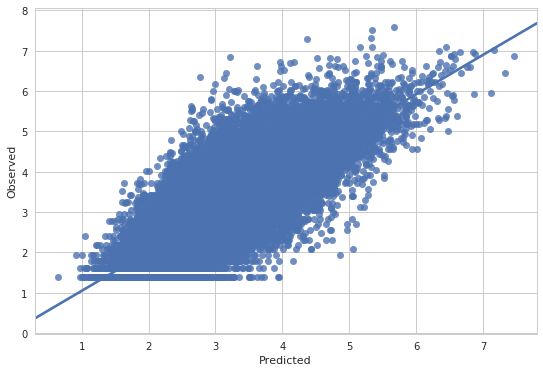

In [23]:
ax = sns.regplot(x=y_pred_valid, y=y_train.iloc[valid_ids])
ax.set(xlabel='Predicted', ylabel='Observed')

[Text(0,0.5,'Residuals'), Text(0.5,0,'Predicted')]

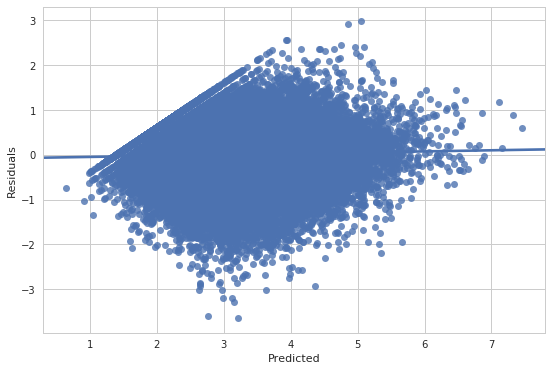

In [24]:
ax2 = sns.regplot(x=y_pred_valid, y=residuals)
ax2.set(xlabel='Predicted', ylabel='Residuals')

In [25]:
# eli5.show_weights(model, vec=vectorizer, feature_filter=lambda x: 'dji' in x)
# print(eli5.show_weights.__doc__)
eli5.show_weights(model, vec=vectorizer)

Weight?,Feature
+2.975,<BIAS>
+1.864,item_description__14k
+1.856,item_description__limbs
+1.682,name__dockatot
+1.655,item_description__unlocked
+1.571,brand_name__david yurman
+1.551,name__tieks
+1.533,item_description__500gb
+1.519,item_description__carat
+1.478,item_description__64gb


In [26]:
# eli5.show_weights(model, vec=vectorizer, feature_filter=lambda x: 'name__3' in x)
eli5.show_weights(model, vec=vectorizer, feature_filter=lambda x: bool(re.match('name__bundle',x)))

In [27]:
bool(re.match('name__\d+$', 'name__32'))

True

In [28]:
# merge.loc[residuals.nlargest(5).index[0]]
large = 0
eli5.show_prediction(model, doc=merge.loc[residuals.nlargest(5).index[large]], vec=vectorizer)

In [29]:
small = 0
eli5.show_prediction(model, doc=merge.loc[residuals.nsmallest(5).index[small]], vec=vectorizer, preserve_density=False)

In [51]:
# print(dir(eli5))
# print(eli5.explain_weights.__doc__)
eli5.format_as_dict(eli5.explain_weights(model, vec=vectorizer, feature_filter=lambda x: bool(re.match('name__four',x))))

{'decision_tree': None,
 'description': "\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n",
 'error': None,
 'estimator': "Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100,\n   normalize=False, random_state=101, solver='auto', tol=0.05)",
 'feature_importances': None,
 'highlight_spaces': None,
 'is_regression': True,
 'method': 'linear model',
 'targets': [{'feature_weights': {'neg': [{'feature': 'name__four leaf',
      'std': None,
      'value': None,
      'weight': -0.21961799777447102},
     {'feature': 'name__fourth',
      'st

In [30]:
small = 0
eli5.show_prediction(model, doc=merge.loc[residuals.nsmallest(20).index[small]], vec=vectorizer)

In [31]:
large = 0
eli5.show_prediction(model, doc=merge.loc[residuals.nlargest(5).index[large]], vec=vectorizer)

Find the index of the biggest errors. Really analyze them to see what happened.

In [32]:
nsmall_merge = merge.loc[residuals.nsmallest(len(residuals)).index]
nsmall_merge[:30]#.loc[1299171,'item_description']

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2
723675,Versace,2,3 chain versace bracelet,Vintage Versace 3 chain bracelet,950.0,1,723675,Vintage & Collectibles,Jewelry,Bracelet
959353,Victoria's Secret,1,Victoria Secret Flavored Lip Gloss Flavors per...,(280) Victoria Secret Lip Gloss,575.0,0,959353,Beauty,Makeup,Lips
451470,PINK,3,"POST IS FOR A LARGE VS PINK DISPLAY DOG, DOG I...",LARGE VS PINK DISPLAY DOG,625.0,1,451470,Women,Other,Other
1208951,missing,3,Posted for Jake,Posted For jake,556.0,0,1208951,Women,Women's Handbags,Shoulder Bag
366444,missing,1,New with tags,Bundle of 8 Swims and 6 Tops,480.0,1,366444,Kids,Boys 0-24 Mos,Swimwear
592820,missing,1,Selling 2 two-day tickets to escape. [rm] each...,Escape 2016 two 2-day tix,400.0,1,592820,Other,Other,Other
1266496,missing,2,EUC Frans Everly Selling as a set at this time,Jessica only,280.0,1,1266496,Handmade,Jewelry,Jewelry
127370,missing,1,38 irmas/perfect t solids mix,Bundle for kels1669,760.0,1,127370,Women,Athletic Apparel,Shirts & Tops
702780,Sephora,2,"Foundation, eyeshadow,concealer and much more ...",Make up,265.0,1,702780,Beauty,Makeup,Makeup Sets
1323713,Louis Vuitton,2,Band new purchase it 9/20/16 at south coast pl...,Brand new DUOMO hobo,1459.0,0,1323713,Women,Women's Handbags,Hobo


In [33]:
nsmall_merge.loc[865132, 'item_description']

'Excellent Condition.'

In [34]:
import re
def get_qntys(data):
  qnty_matches = []
  qnty_re = [r'(\d+) ?x [^\d]', r'(\d+) ?pairs?']
  for r in qnty_re:
    qnty_matches.append(
        data.name.str.extract(r, flags=re.IGNORECASE, expand=False).dropna()
        .astype(int))
  return qnty_matches


In [35]:
r = r'(\d+) ?x [^\d]'
b = r'(\d+) ?pairs?'
d = '(\d+)'
nsmall_qnt = nsmall_merge.name.str.extract(d, expand=False).fillna(value=1).astype(int)

In [36]:
nsmall_samples = nsmall_qnt.sample(20)
# print(nsmall_samples)
nsmall_merge.loc[nsmall_samples[nsmall_samples>1].index]

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2
219227,missing,1,2 rechargeable batteries and charging cord. St...,2 xbox one rechargeable batteries/cable,13.0,1,219227,Electronics,Video Games & Consoles,Accessories
1381423,Lysol,1,New with tags Price is firm. No free shipping....,BIG PACK 3 NEW LYSOL WIPES BOTTLES,18.0,0,1381423,Home,Cleaning Supplies,Household Cleaners
859334,missing,1,Vampire Teeth Nipple Piercing / Rings 14g Surg...,Vampire Teeth Nipple Rings 14G,9.0,0,859334,Women,Jewelry,Rings
548445,Xbox,1,Brand New and Factory Sealed Works with Xbox 1...,Gears of War 4 Ultimate Edition (Xbox 1),49.0,1,548445,Vintage & Collectibles,Electronics,Video Game
246756,Nintendo,3,Red 3DS restored to factory settings Yellow pe...,Nintendo 3DS,41.0,0,246756,Electronics,Video Games & Consoles,Consoles


In [37]:
nsmall_merge.loc[857248,'item_description']

'Gently used in good used condition. Slight discoloration but not too noticeable.'

In [38]:
print(nltk.pos_tag(["all"]))

[('all', 'DT')]


In [39]:
real_n = nsmall_qnt[nsmall_qnt.between(100,200,inclusive=False)]

In [40]:
nsmall_merge.loc[real_n.index]

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2
519936,missing,2,"Great for vacations, boring jobs and anything ...",Sentry G155,115.0,0,519936,Electronics,Video Games & Consoles,Accessories
986083,missing,3,128 muscle men. 1 robot guy has broken arm. Ot...,128 M.U.S.C.L.E. Men.,100.0,1,986083,Vintage & Collectibles,Toy,Action Figure
1290134,missing,1,"1x Bambina 160g 20"" Ash Blonde (60) - BELLAMI ...","NEW! Bambina 160g 20"" ASH BLONDE",104.0,0,1290134,Women,Women's Accessories,Hair Accessories
711635,missing,1,Selling 10 boxes of 12. They go for about [rm]...,120 quest bars,110.0,1,711635,Other,Daily & Travel items,Sports Nutrition
525884,missing,3,"Designed with everyone in mind, the Sentry is ...",Sentry Gaems G155 gaming environment,135.0,0,525884,Vintage & Collectibles,Electronics,Video Game
998904,missing,1,Reorder 5sheets custom logo stickers for slime...,Slime Confession(120) Circle Sticker,15.0,1,998904,Other,Office supplies,Shipping Supplies
72444,missing,2,Curly Wurly Shampoo Oatifix Cupcake Monsters B...,Reserved...dany123 Lush Curly Wurly,75.0,1,72444,Handmade,Accessories,Hair
1285214,missing,1,No description yet,Lot worth 109$ kawaii stationery,40.0,1,1285214,Other,Daily & Travel items,Stationery & Party Supplies
672739,Carter's,3,"Some 3-6 month, mostly 6, 6-9, and 9 month. Yo...",140+ Pieces Baby Girl Clothes,80.0,0,672739,Kids,Girls 0-24 Mos,One-Pieces
285101,missing,3,asMOdus minikin 1.5. Goes up to 150w. Does not...,asMODus Box 150W,44.0,0,285101,Other,Daily & Travel items,Other


In [224]:
# merge.loc[real_n.index]

In [41]:
merge.loc[698546]

brand_name                                                       Apple
item_condition_id                                                    3
item_description     Good condition. Intel Core i7 processor. 750GB...
name                          Apple MacBook Pro 13.3" laptop late 2011
price                                                              400
shipping                                                             1
train_id                                                        698546
general_cat                                                Electronics
subcat_1                                           Computers & Tablets
subcat_2                                            Laptops & Netbooks
Name: 698546, dtype: object

0. If Bundle in either item or item description, then please use 1. If not, use 0

1. Include Adjective after digit
2. Convert number (in words) into digits
3. It should be two digits
4. Word after should be proper noun or noun
5. Word after is in plural means more confident
6. i cannot be before the number. Inch cannot be after the number (698546)
7. D cannot be after the number
8. iphone 7 plus. iPhone cannot be before the number (113936)
9. - cannot be after the number (689253)
10. Size cannot be before the number or after number (894460)
11. PCS immediately after word - increases confidence (449176)
12. Word "Bundle" in name - increases confidence (865183)
13. <s>Cannot have # in name (1134591)</s>
14. Set in name (1081163)
15. <s>SONOS Play (865132). This has 5 in it.</s>
16. If Bundle, look for value in the name or item description (127370, 366444)
17. Maybe 97 too high? (560647)
18. x before or after digit (322667	, 1127718	)
19. Apple Watch 38MM (137645, 923655)
20. Single letter before number (467152)
21. Lot of 3 (230407)
22. Number before digit and digit before number (366444)
23. Forever 21 should never be there.
24. In brackets (
25. Air Max 90 - 271233	
26. 

Things which ought to pass are:
1. 805559
2. 723675
3. 1013687	- 10
4. 1249832	- 2

Things which are left out:
1. Converting Words to Numbers (do further investigations on the errors)
2. 

In [106]:
def get_q(data):
  """
	Gets two columns ('name' & 'item_description') Pandas Dataset and then
	returns the expected quantity.
	"""
  des_n = re.findall(r'\d+', data['item_description'])
  name_n = re.findall(r'\d+', data['name'])
  # import ipdb; ipdb.set_trace()
  if len(des_n) == 1 and len(name_n) == 1:
    if des_n[0] == name_n[0]:
      ret_n = int(des_n[0])
    else:
      ret_n = 1
    return ret_n


In [100]:
merge[['item_description', 'name']].loc[449176]

item_description    Naked 12pc professional makeup brush set with ...
name                         Naked 12pc Professional makeup Brush Set
Name: 449176, dtype: object

In [11]:
merge['num'] = merge[['item_description','name']].apply(get_q, axis=1)

In [113]:
print(merge['num'].loc[723674])

nan


In [112]:
merge['num'] = merge['num'].astype(str)

In [116]:
merge[merge['num'] != 'nan']

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2,num
21,Victoria's Secret,1,NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...,NWT VS ULTIMATE SPORTS BRA 34ddd,20.0,0,21,Women,Athletic Apparel,Sports Bras,34.0
25,Air Jordan,3,They are 100 percent authentic. They are beate...,Air Jordan carmine 6s,66.0,0,25,Men,Shoes,Athletic,1.0
32,PINK,1,Pink bra with logo band! 36d push up,Pink bra 36d,22.0,0,32,Women,Underwear,Bras,36.0
39,Victoria's Secret,3,Victoria secret 34 c corest top Will bundle to...,Victoria secret 34 c corest top,10.0,0,39,Women,Underwear,Bras,34.0
79,Sea Wees,3,Great condition sea wees size 0 brown,Sea wees size 0,14.0,0,79,Kids,Girls 0-24 Mos,Shoes,0.0
92,Silver Jeans Co.,3,Distressed with holes. Great shape well taken ...,Silver jeans size 11,16.0,0,92,Women,Jeans,Boot Cut,11.0
97,missing,2,Bling Mickey ear case!! Just used one for a Di...,iPhone 5S Mickey ear case,9.0,1,97,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",1.0
121,missing,2,Tens 3000 Have back pain?? Then this would be ...,Tens 3000 LOWERED PRICE,16.0,0,121,Other,Daily & Travel items,Medical Supplies & Equipment,3000.0
152,missing,1,NWT 32D Victoria Secret Bling Lined Demi Bra,NWT 32D Victoria Secret Bling Bra,29.0,0,152,Women,Underwear,Bras,32.0
155,missing,3,For aferg16.,3 Nora Roberts Books,10.0,1,155,No Label,No Label,No Label,1.0


In [92]:
print(merge.loc[1469806])

brand_name                        missing
item_condition_id                       1
item_description              new in box.
name                 Hp 11x Ink cartridge
price                                 NaN
shipping                                0
train_id                          1469806
general_cat                         Other
subcat_1                  Office supplies
subcat_2                      Ink & Toner
qnt                                    11
hyphen                                  0
Name: 1469806, dtype: object


In [103]:
train.loc[113936,'name']

'Iphone 7 plus case'

In [42]:
r = r'(?<!#|\d|S|\.|/|k)(?<!Play\s|size\s|Note\s|xbox\s)(?<!sz\.|sz\s)(?<!sz|\d\s)(?<!iphone\s)(?<!forever)(?<!Nintendo\s)(?<!forever\s)(?<!xbox)(\d+)(?!D{1,4}|C|\'|"|T|G|\.|\s?c\s|\d|\s?K|\s?[Mm]{2}|s|\s?hour|\s?month|\s?day)'
t_str = "Girls Nike Shox size 2c EEUC, no noticeable flaws"
t_str1 = "3 chain versace bracelet"
t_str2 = "NWT 42D Victoria Secret Bling Lined Demi Bra"
t_str3 = "38 irmas/perfect t solids mix"
t_str4 = "45x new earbuds for [rm], free shipping"
t_str5 = "Foundation, eyeshadow,concealer and much more 80+ pieces of make up"
t_str6 = "MOOD COLOR CHANGE ~ #04 NAIL POLISH NEW!"
t_str7 = "(280) Victoria Secret Lip Gloss"
t_str8 = "38 MM Coral Apple Watch"
t_str9 = "38 mm Coral Apple Watch"
t_str10 = "Apple Watch Stainless Steel Brace 42mm"
t_str11 = "Victoria secret 34 c corest top Will bundle to save on shipping\
If you have any questions please feel free to ask"
t_str12 = "SONOS Play 5 ZonePlayer S5 Audio Player"
t_str13 = "SONOS PLAY 1"
t_str14 = "Set of 2 Eye Stencils Smokey & Cat Eye"
t_str15 = "Naked 12pc Professional makeup Brush Set"
t_str16 = "Iphone 7 plus case"
t_str17 = "24K GOLD plated rose"
t_str18 = "NWT VS ULTIMATE SPORTS BRA 34ddd"
t_str19 = "Air Jordan carmine 6s"
t_str20 = "Forever21 floral romper strapless"
t_str21 = "NWT forever 21 cropped tee"
t_str22 = "5 forever 21 cami tank tops"
t_str23 = "Galaxy S7 Edge (Unlocked) 32GB"
t_str24 = "Led kids shoes size 3 and size 9"
t_str25 = "Boots NWT 6.5"
t_str26 = "Manolo blanik sz 35 1/2"
t_str27 = "NBA 2k14 BRAND NEW SEALED"
t_str28 = "Hamilton Beach electric kettle 10C"
t_str29 = "MineCraft xbox360"
t_str30 = "Rockstar Bundle (Xbox 360 / One)"
t_str31 = "New carters top girls 9 months"
t_str32 = "Nintendo 64 1080 Nowboarding"
t_str33 = "Nintendo 64 Men's Shirt"
t_str34 = "Nintendo 64 3 games"
t_str35 = "21 day fix containers and eating plan"
t_str36 = "18 k Saudi Gold bangle"


print(re.findall(r, t_str, re.IGNORECASE), 0)
print(re.findall(r, t_str1, re.IGNORECASE), 3)
print(re.findall(r, t_str2, re.IGNORECASE), 0)
# print(re.findall(r'[\bx]\d+[\bx]', t_str2))
print(re.findall(r, t_str3, re.IGNORECASE), 38)
print(re.findall(r, t_str4, re.IGNORECASE), 45)
print(re.findall(r, t_str5, re.IGNORECASE), 80)
print(re.findall(r, t_str6, re.IGNORECASE), 0)
print(re.findall(r, t_str7, re.IGNORECASE), 280)
print(re.findall(r, t_str8, re.IGNORECASE), 0)
print(re.findall(r, t_str9, re.IGNORECASE), 0)
print(re.findall(r, t_str10, re.IGNORECASE), 0)
print(re.findall(r, t_str11, re.IGNORECASE), 0)
print(re.findall(r, t_str12, re.IGNORECASE), 0)
print(re.findall(r, t_str13, re.IGNORECASE), 0)
print(re.findall(r, t_str14, re.IGNORECASE), 2)
print(re.findall(r, t_str15, re.IGNORECASE), 12)
print(re.findall(r, t_str16, re.IGNORECASE), 0)
print(re.findall(r, t_str17, re.IGNORECASE), 0)
print(re.findall(r, t_str18, re.IGNORECASE), 0)
print(re.findall(r, t_str19, re.IGNORECASE), 0)
print(re.findall(r, t_str20, re.IGNORECASE), 0)
print(re.findall(r, t_str21, re.IGNORECASE), 0)
print(re.findall(r, t_str22, re.IGNORECASE), 5)
print(re.findall(r, t_str23, re.IGNORECASE), 0)
print(re.findall(r, t_str24, re.IGNORECASE), 0)
print(re.findall(r, t_str25, re.IGNORECASE), 0)
print(re.findall(r, t_str26, re.IGNORECASE), 0)
print(re.findall(r, t_str27, re.IGNORECASE), 0)
print(re.findall(r, t_str29, re.IGNORECASE), 0)
print(re.findall(r, t_str30, re.IGNORECASE), 0)
print(re.findall(r, t_str31, re.IGNORECASE), 0)
print(re.findall(r, t_str32, re.IGNORECASE), 0)
print(re.findall(r, t_str33, re.IGNORECASE), 0)
print(re.findall(r, t_str34, re.IGNORECASE), 0)
print(re.findall(r, t_str35, re.IGNORECASE), 0)
print(re.findall(r, t_str36, re.IGNORECASE), 0)

[] 0
['3'] 3
[] 0
['38'] 38
['45'] 45
['80'] 80
[] 0
['280'] 280
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
['2'] 2
['12'] 12
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
['5'] 5
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0


In [43]:
%%time
# merge['qnt_1'] = merge.name.str.extract(r, expand=False).fillna(value=1).astype(int)
merge['qnt'] = merge.name.str.extract(r, re.IGNORECASE, expand=False).fillna(value=1).astype(int)
# def cut(x):
#     if x > 0 and x < 300:
#         return x
#     else:
#         return 1
merge['qnt'] = np.where(merge['qnt'] < 300, merge['qnt'], 1)


CPU times: user 13.2 s, sys: 40 ms, total: 13.2 s
Wall time: 13.2 s


In [86]:
merge[:nrow_train][merge[:nrow_train]['qnt']==0]

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2,qnt
771,missing,2,This is an adorable dressy baby boy holiday ou...,Koala Baby 0-3 Month Baby Boy Outfit,8.0,1,771,Kids,Boys 0-24 Mos,Tops & T-Shirts,0
1250,missing,3,Pink Sparkly TOMS Size T6,Pink sparkly TOMS. Tmarie00,19.0,0,1250,Kids,Girls 2T-5T,Shoes,0
2128,missing,1,Super Cute! New with Tags. Brand New. Never Wo...,Baby Ladybug Halloween Costume 0-3 Month,12.0,1,2128,Kids,Girls 0-24 Mos,One-Pieces,0
3818,missing,3,All excellent condition and barley worn,0-3 month oncies,13.0,0,3818,Kids,Girls 0-24 Mos,One-Pieces,0
5966,missing,3,Gently worn baby boy clothes. My son wore mayb...,0-3 month lot,11.0,0,5966,Kids,Boys 0-24 Mos,One-Pieces,0
6605,Carter's,3,Baby boy clothes 2 luvable friends 3-6 m pants...,Baby boy bundle 0-18 mos.,21.0,0,6605,Kids,Boys 0-24 Mos,One-Pieces,0
8839,American Eagle,3,American Eagle jeggings size 0 Great condition,American Eagle jeggings 0,14.0,0,8839,Women,Jeans,"Slim, Skinny",0
8931,missing,3,Mudpie Halloween 0-6 months Comes from clean s...,Mudpie 0-6 months,12.0,1,8931,Kids,Boys 0-24 Mos,One-Pieces,0
9802,missing,2,All clothes that I have posted have been washe...,0-3 month football Auburn tigers onesie,5.0,1,9802,Kids,Boys 0-24 Mos,One-Pieces,0
10858,Hollister,3,good condition size 0,hollister skinny jeans 0,18.0,0,10858,Women,Jeans,"Slim, Skinny",0


In [74]:
from scipy.sparse import coo_matrix
merge[:nrow_train][merge[:nrow_train]['qnt']>1]
print(merge[:nrow_train]['qnt'].shape)
X_train.ndim
coo_matrix(merge[:nrow_train]['qnt']).shape
# merge[:nrow_train]['qnt'].ndim
X_train = hstack((X_train, merge[:nrow_train].loc[:,['qnt']].to_sparse()))
# merge[:nrow_train].loc[:,['qnt']]

(1481661,)


In [77]:
X_train.getcol.__doc__

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__numpy_ufunc__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add_dense',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_check',
 '_deduped_data',
 '_divide',
 '_get_dtype',
 '_imag',
 '_min_or_max',
 '_min_or_max_axis',
 '_mul_multivector',
 '_mul_scalar',
 '_mul_sparse_matrix',
 '_mul_ve

In [101]:
X_train.getcol(-1).todense().dtype

dtype('float64')

In [87]:
def get_q(data):
  """
	Gets two columns ('name' & 'item_description') Pandas Dataset and then
	returns the expected quantity.
	"""
  des_n = re.findall(r'\d+', data['item_description'])
  name_n = re.findall(r'\d+', data['name'])
  # import ipdb; ipdb.set_trace()
  if len(des_n) == 1 and len(name_n) == 1:
    if des_n[0] == name_n[0]:
      ret_n = int(des_n[0])
    else:
      ret_n = 1
    return ret_n


# Find all of the rows which have `x` in it.
# Find all the rows with "Play or play" in them
def get_play(data):
    r = r'(\d+(?=-))'
    if re.findall(r, data['name'], re.IGNORECASE):
        ret_n = 1
    else:
        ret_n = 0
    return ret_n

In [88]:
merge['hyphen'] = merge[['item_description','name']].apply(get_play, axis=1)

In [89]:
merge[merge['hyphen'] == 1]

,brand_name,item_condition_id,item_description,name,price,shipping,train_id,general_cat,subcat_1,subcat_2,qnt,hyphen
237,Nintendo,2,Lego Harry Potter Years 1-4 Wii E10+ Warner Br...,Lego Harry Potter Years 1-4 Wii,19.0,0,237,Electronics,Video Games & Consoles,Games,1,1
352,missing,2,2-Mens XXL Cruise Ship T-Shirts. Grey-Royal Ca...,2-Mens XXL Cruise Ship T-Shirts NWOT,9.0,0,352,Men,Tops,T-shirts,2,1
480,missing,1,Brush with Bamboo’s 2-pack includes 2 Adult to...,BAMBOO ADULT TOOTHBRUSH 2-PACK,15.0,1,480,Other,Daily & Travel items,Personal Care,2,1
603,missing,2,3 month to 6 month 3/9 swim set LIKE NEW!! Fre...,3-6 month swim set,9.0,1,603,Kids,Boys 0-24 Mos,Swimwear,3,1
652,missing,3,Girl bundle 6-9 months everything is in good c...,6-9 months bundle,18.0,1,652,Kids,Girls 0-24 Mos,Tops & T-Shirts,6,1
771,missing,2,This is an adorable dressy baby boy holiday ou...,Koala Baby 0-3 Month Baby Boy Outfit,8.0,1,771,Kids,Boys 0-24 Mos,Tops & T-Shirts,0,1
834,Carter's,3,"10 pj's, 21 onsie's, 12 pants, 8 outfits, 7 to...",3-6 Month Baby Clothes,39.0,0,834,Kids,Girls 0-24 Mos,One-Pieces,3,1
1002,missing,1,New Cloth diapering pants Maxaloones,Minoloones size 3-12 months cloth pants,14.0,1,1002,Kids,Boys 0-24 Mos,Bottoms,1,1
1043,Nike,1,"Never worn, og all. Size 3c. Yes it has box an...",Infant Jordan 11 72-10,46.0,0,1043,Kids,Boys 0-24 Mos,Shoes,11,1
1044,Children's Place,3,Great condition 3-in-1 jacket from The Childre...,TCP xs/4 3-in-1 winter jacket and scarf,12.0,0,1044,Kids,Boys 2T-5T,Coats & Jackets,1,1


In [ ]:
(1481661, 155812)